# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
import nltk
from nltk.corpus import stopwords
 
from tqdm import tqdm
from datetime import datetime
 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Overview

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/train_clean_final.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332507 entries, 0 to 2332506
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   BROWSE_NODE_ID  int64 
 1   CLEANED TEXT    object
dtypes: int64(1), object(1)
memory usage: 35.6+ MB


In [6]:
df.head()

,BROWSE_NODE_ID,CLEANED TEXT
0,0,cat blue doll inch cat popular cat new cat blu...
1,1,new refrigerator magnet new cello wrapped hard...
2,-1,ultimate self complete guide baking craft gard...
3,3,kid iron tablet kid iron tablet quantity tablet
4,4,teacher planner company lesson teacher planner...


In [7]:
df.isnull().sum()

BROWSE_NODE_ID    0
CLEANED TEXT      0
dtype: int64

In [8]:
df.duplicated().sum()

0

# Visualizing 

In [ ]:
#unique, counts = np.unique(df['BROWSE_NODE_ID'], return_counts=True)

#print(np.asarray((unique, counts)))

[[    -1      0      1 ... 166575 215592 267793]
 [128587   2685   1543 ...     81     75     64]]


In [ ]:
#print(len(unique))

2760


In [ ]:

'''
sort_index = np.argsort(-counts)
counts = counts[sort_index]
unique = unique[sort_index]

print(unique)
print(counts)
'''

[ 1045    -1     5 ... 14156 44878  2788]
[139321 128587  52140 ...     54     50     18]


In [ ]:
'''
cdf = np.cumsum(counts)
cdf = (cdf/len(df['BROWSE_NODE_ID']))*100
print(cdf)
'''

[  5.9730153   11.48583906  13.72120212 ...  99.99708468  99.9992283
 100.        ]


In [ ]:
#cdf_index = list(range(0,len(cdf)))

In [ ]:
#np.argwhere(cdf>95)[0], np.argwhere(cdf>90)[0]

(array([1726]), array([1201]))

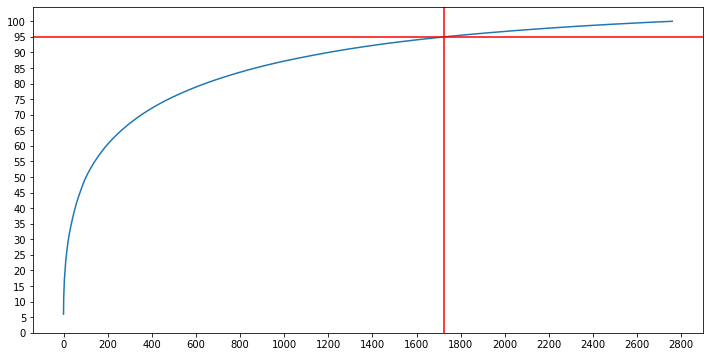

In [ ]:
'''
plt.figure(figsize = (12,6))
plt.plot(cdf_index,cdf)
plt.axhline(95, c='red')
plt.axvline(1726, c='red')
plt.yticks(np.arange(0,101,5))
plt.xticks(np.arange(0,3000,200))
plt.show()
'''

In [ ]:
'''
UNIQUE = [str(i) for i in unique]
print(len(UNIQUE))
print(UNIQUE[:5])
'''

2760
['1045', '-1', '5', '1251', '1052']


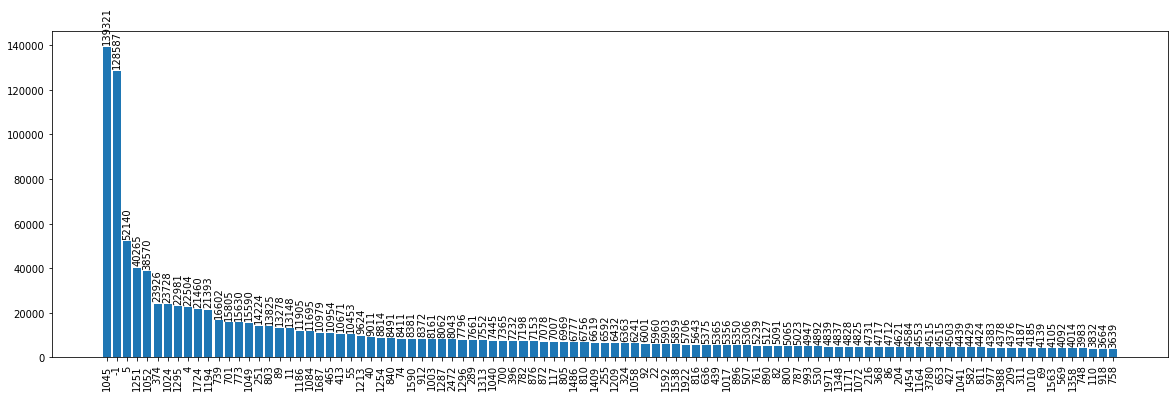

In [ ]:
'''
plt.figure(figsize = (20,6))
plt.bar(UNIQUE[:100],counts[:100])
plt.xticks(rotation=90)

for index, value in enumerate(counts[:100]):
    plt.text(index, value+2000, str(value), horizontalalignment='center', rotation=90)

plt.show()
'''

In [ ]:
#unique

array([ 1045,    -1,     5, ..., 14156, 44878,  2788])

In [ ]:
#np.log(unique)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


array([ 6.95177216,         nan,  1.60943791, ...,  9.55789384,
       10.71170298,  7.93307977])

In [ ]:
#np.exp(np.log(unique))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


array([1.0450e+03,        nan, 5.0000e+00, ..., 1.4156e+04, 4.4878e+04,
       2.7880e+03])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


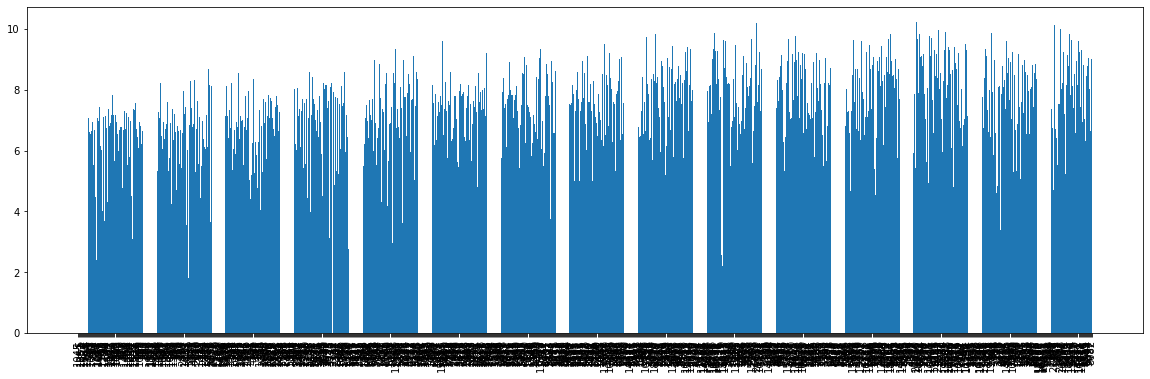

In [ ]:
'''
plt.figure(figsize = (20,6))
plt.bar(UNIQUE[:1000],np.log(unique)[:1000])
plt.xticks(rotation=90)

#for index, value in enumerate(counts[:100]):
    #plt.text(index, value+2000, str(value), horizontalalignment='center', rotation=90)

plt.show()
'''

# Loading Corpus and other node id

In [9]:
with open('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/corpus.txt','r') as f:
  corpus = f.readline().split(',')[:-1]
  corpus = np.array(corpus)

print(len(corpus))
print(corpus[:10])

8138
['hardness' 'bulletin' 'splitter' 'mustard' 'heard' 'usually'
 'transferring' 'functional' 'tourmaline' 'court']


In [10]:
f = open('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/other_node_id.txt', 'r')

other_node_id = [int(i) for i in f.readline().split(',')[:-1]]

f.close()
print(other_node_id)

[15967, 3186, 15800, 8507, 31189, 12978, 32005, 588, 1386, 31871, 35508, 26655, 39381, 181727, 8846, 51359, 7331, 5347, 51174, 15698, 26940, 46786, 68849, 881, 8491, 16763, 1879, 31882, 22472, 25109, 40545, 22237, 420, 6035, 122852, 55588, 31956, 17956, 23117, 2467, 295, 85381, 11039, 10487, 46925, 78615, 103853, 59540, 8750, 17565, 18347, 450, 1831, 38762, 82027, 2830, 45510, 16720, 93129, 14776, 9103, 38214, 95704, 3699, 29897, 30003, 58087, 52086, 1245, 287, 7534, 363, 167904, 5418, 25573, 85585, 58783, 38176, 29856, 30478, 44409, 121775, 20705, 4527, 4493, 5067, 8198, 2121, 9496, 3097, 578, 3106, 7242, 102, 30642, 24074, 3255, 4135, 66550, 213026, 7057, 6653, 2408, 28876, 25444, 4372, 545, 15469, 15038, 39991, 51388, 32664, 138909, 107, 9766, 33225, 24813, 1993, 8722, 38562, 2577, 76398, 23925, 26398, 83642, 37520, 22996, 27486, 18298, 14905, 44828, 2547, 64855, 16919, 60488, 30062, 11921, 25094, 30520, 33368, 6983, 1737, 19341, 877, 6719, 78880, 31490, 47530, 102411, 551, 14768, 1

In [11]:
other_node_id = np.array(other_node_id)
len(other_node_id)

7160

# Split Data

In [12]:
#label encoding
le = LabelEncoder()
Y = le.fit_transform(df['BROWSE_NODE_ID'])

In [13]:
le.classes_, Y

(array([    -1,      0,      1, ..., 166575, 215592, 267793]),
 array([  1,   2,   0, ...,  36, 627, 242]))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['CLEANED TEXT'], 
                                                    Y,
                                                    test_size=0.2, 
                                                    random_state=0)
 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1866005,)
(466502,)
(1866005,)
(466502,)


In [19]:
X_train[:2], y_train[:2]

(455188     hair treatment oil black pearl protein cell im...
 2154809    woman modern cotton bikini panty purple small ...
 Name: CLEANED TEXT, dtype: object, array([152, 667]))

In [20]:
print(type(X_train), type(y_train))

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


# Preparing Data for modeling small dataset

In [ ]:
temp = df[:1000]
temp

,BROWSE_NODE_ID,CLEANED TEXT,Encoded_BROWSE_NODE_ID
0,0,cat blue doll inch cat popular cat new cat blu...,1
1,1,new refrigerator magnet new cello wrapped hard...,2
2,-1,ultimate self complete guide baking craft gard...,0
3,3,kid iron tablet kid iron tablet quantity tablet,3
4,4,teacher planner company lesson teacher planner...,4
...,...,...,...
1022,40,flying machine men prince slim fit jean blue c...,30
1023,1023,sleepwear boy play well pajama navy blue watch...,522
1024,1024,united color benetton men casual shirt small b...,523
1025,69,bburago diecast motorcycle red bburago diecast...,44


In [ ]:
len(temp.Encoded_BROWSE_NODE_ID.value_counts())

524

In [ ]:
np.array(temp['CLEANED TEXT'])[0:2]

array(['cat blue doll inch cat popular cat new cat blue doll rock striped red slipper one cat ready measure inch tall safe age removable clothing surface wash new cat blue plush doll based popular cat book super cuddly ready safe age perfect age measure inch',
       'new refrigerator magnet new cello wrapped hard magnet measure inch width inch height highlight one many beautiful new cover full color cat tea cup new cover artist cat tea cup new cover artist cello wrapped hard magnet ideal home office gift new magazine lover highlight one many beautiful new cover full color rigid magnet measure inch width inch height new'],
      dtype=object)

In [ ]:
def max_length(series):
  maxlen = 0
  for text in tqdm(series):
    length = len(set(text.split()))    
    if maxlen < length:
      maxlen = length
  return maxlen

In [ ]:
max_length(temp['CLEANED TEXT'])

100%|██████████| 10/10 [00:00<00:00, 41775.94it/s]


61

# Tokenizer

In [21]:
tokenizer = Tokenizer()         #oov_token = 'OOV'

In [22]:
start = datetime.now()
 
tokenizer.fit_on_texts(X_train)
 
end = datetime.now()
print(f'Time take to train tokenizer is:', end - start)

Time take to train tokenizer is: 0:01:56.496443


In [ ]:
dir(tokenizer)

In [23]:
print(tokenizer.document_count)
print(tokenizer.index_docs)
print(tokenizer.index_word)
print(tokenizer.num_words)
print(tokenizer.oov_token)
print(tokenizer.word_counts)
print(tokenizer.word_docs)
print(tokenizer.word_index)

1866005
defaultdict(<class 'int'>, {1599: 14974, 111: 46185, 30: 311291, 757: 31164, 1363: 8862, 883: 17892, 170: 67502, 1131: 23031, 1271: 17692, 1671: 5782, 2481: 7299, 82: 201724, 1018: 10314, 25: 303393, 4758: 1487, 1740: 13937, 758: 34916, 397: 68040, 31: 330461, 1548: 7033, 767: 32907, 2182: 8330, 456: 52629, 1268: 18925, 936: 24540, 11: 377726, 410: 63891, 4518: 1210, 143: 139483, 1020: 22750, 8: 503121, 15: 342322, 92: 188255, 406: 68218, 702: 33878, 188: 115147, 477: 53721, 353: 81864, 444: 32152, 1356: 18337, 119: 148925, 756: 26420, 591: 30003, 2165: 7036, 13: 478913, 99: 140074, 1014: 24867, 165: 104333, 533: 55024, 3454: 3545, 1574: 15894, 257: 100746, 2205: 8422, 35: 204249, 1: 736297, 1326: 16169, 122: 166280, 419: 56357, 688: 35196, 1396: 18210, 488: 41361, 1786: 9888, 3240: 3960, 657: 37005, 1358: 18644, 2327: 8040, 1636: 14162, 1658: 14612, 363: 71639, 218: 72979, 652: 34356, 670: 37750, 190: 124308, 577: 50002, 838: 35081, 33: 307625, 5712: 643, 325: 77152, 154: 1527

In [24]:
len(tokenizer.word_counts)

8137

In [25]:
 tokenizer.texts_to_matrix(['cat blue flash learning flash'], mode='count')

array([[0., 0., 0., ..., 0., 0., 0.]])

In [26]:
 tokenizer.texts_to_matrix(['cat blue flash learning flash'], mode='count').shape

(1, 8138)

In [ ]:
tokenizer.texts_to_sequences(['cat blue flash the learning flash to',
                              'blue amzo'])

[[900, 68, 1027, 1804, 1027], [68]]

In [ ]:
tokenizer.sequences_to_texts(tokenizer.texts_to_sequences(['cat blue flash the learning flash to',
                              'blue amzo']))

['cat blue flash learning flash', 'blue']

# Data Generator and Model

In [27]:
class Data_Generator(tf.keras.utils.Sequence):
    """
    Helper function to iterate over the data (as Numpy arrays).
    """
 
    def __init__(self, batch_size, input_text_series, target_label_series):
        self.batch_size = batch_size
        self.input_text_series = input_text_series
        self.target_label_series = target_label_series
 
    def __len__(self):
      '''
      returns the number of batches per epoch.
      '''
      return len(self.input_text_series) // self.batch_size                    # len(X_train)//batch_size
 
    def __getitem__(self, index):
        """
        Returns tuple (input, target) correspond to one batch at index.
        """
 
        iterator = index * self.batch_size                                        # 0*batch_size
                                                          
        x_batch = self.input_text_series[iterator : iterator + self.batch_size]                 # [0: 0+batch_size]
        y_batch = self.target_label_series[iterator : iterator + self.batch_size]             # [0: 0+batch_size]
 
        x_batch = tokenizer.texts_to_matrix(x_batch, mode='count')
 
        return np.asarray(x_batch), np.asarray(y_batch)

In [34]:
# checking gererator function
batch_size = 256
train_gen = Data_Generator(batch_size,
                           np.array(X_train),
                           np.array(y_train))
                           
val_gen = Data_Generator(batch_size,
                         np.array(X_test),
                         np.array(y_test))

In [29]:
train_gen.__len__()

7289

In [30]:
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)

(256, 8138) (256,)


In [32]:
x[0],y[0]

(array([0., 0., 0., ..., 0., 0., 0.]), 152)

In [33]:
print(type(x), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [47]:
#tf.keras.backend.clear_session()

In [35]:
input_shape = (8138,)
num_classes = len(np.unique(y_train))          #len(le.classes_)

print(num_classes)

2760


In [48]:
input_layer = tf.keras.Input(shape = input_shape, dtype="int64")
 
#Dense Layer
x = tf.keras.layers.Dense(2000)(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
 
#Dense Layer
x = tf.keras.layers.Dense(1000)(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
 
#Dense Layer
x = tf.keras.layers.Dense(512)(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

#Dense Layer
x = tf.keras.layers.Dense(512)(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
 
model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8138)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4167168   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2760)              1415880   
Total params: 5,585,096
Trainable params: 5,584,072
Non-trainable params: 1,024
_______________________________________________

In [49]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
 
model.compile(optimizer=opt,
              loss="sparse_categorical_crossentropy", 
              metrics = 'accuracy')  


In [50]:
filepath = "/content/drive/MyDrive/AI_Notebooks_and_Models/Amazon_ML_Challenge_2021/bow_model/bow_model_epoch_{epoch:00d}_valloss_{val_loss:03f}_valacc_{val_accuracy:03f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 5
model_history = model.fit(train_gen, epochs = epochs, validation_data = val_gen, callbacks = callbacks)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', end - start)

Epoch 1/5
 944/7289 [==>...........................] - ETA: 3:50 - loss: 4.5804 - accuracy: 0.3333

In [ ]:
'''start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 1
model_history = model.fit(train_gen, epochs = epochs, validation_data = val_gen, callbacks = callbacks)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', end - start)'''

Epoch 1/4
12755/12755 [==============================] - 391s 30ms/step - loss: 1.4948 - accuracy: 0.6658 - val_loss: 1.4024 - val_accuracy: 0.6893
Epoch 2/4
12755/12755 [==============================] - 394s 31ms/step - loss: 1.4398 - accuracy: 0.6754 - val_loss: 1.4049 - val_accuracy: 0.6949
Epoch 3/4
12755/12755 [==============================] - 403s 32ms/step - loss: 1.4141 - accuracy: 0.6807 - val_loss: 1.4182 - val_accuracy: 0.6967
Epoch 4/4
12755/12755 [==============================] - 400s 31ms/step - loss: 1.3946 - accuracy: 0.6857 - val_loss: 1.4308 - val_accuracy: 0.6986
Time take to train 4 epochs is: 0:26:31.429502


In [ ]:
history = model_history.history
history

{'accuracy': [0.6657732129096985,
  0.6754397749900818,
  0.680739164352417,
  0.6857053637504578],
 'loss': [1.4947656393051147,
  1.4398207664489746,
  1.4140888452529907,
  1.394582748413086],
 'val_accuracy': [0.6892580389976501,
  0.6948679685592651,
  0.6966845989227295,
  0.698578417301178],
 'val_loss': [1.402375340461731,
  1.404880166053772,
  1.4182056188583374,
  1.4307729005813599]}

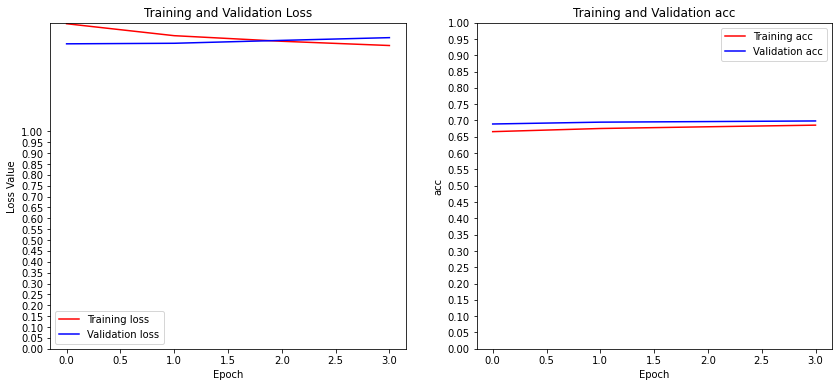

In [ ]:
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']
 
plt.figure(figsize=(14,6))
 
plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yticks(np.arange(0, 1.05,.05))
plt.legend()
 
plt.subplot(1,2,2)
plt.plot(train_acc, 'r', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.yticks(np.arange(0,1.05,.05))
plt.legend()
 
plt.show()

In [ ]:
asaxdsxdfrecd

NameError: ignored

In [ ]:
test = tokenizer.texts_to_matrix(np.array(X_test)[:15])
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
pred = model.predict(test)
print(type(pred))
print(pred.shape)

<class 'numpy.ndarray'>
(15, 2760)


In [ ]:
tf.nn.top_k(pred, k = 1)

TopKV2(values=<tf.Tensor: shape=(15, 1), dtype=float32, numpy=
array([[0.13938873],
       [0.7123111 ],
       [0.35291055],
       [0.9930715 ],
       [0.20929828],
       [0.14242487],
       [0.5340536 ],
       [0.71753925],
       [0.5225294 ],
       [0.24339783],
       [0.59436995],
       [0.09059897],
       [0.44940975],
       [0.75878644],
       [0.8637405 ]], dtype=float32)>, indices=<tf.Tensor: shape=(15, 1), dtype=int32, numpy=
array([[   0],
       [ 533],
       [2121],
       [ 576],
       [ 944],
       [ 448],
       [1381],
       [ 532],
       [ 944],
       [   0],
       [ 943],
       [ 206],
       [ 158],
       [ 437],
       [ 532]], dtype=int32)>)

In [ ]:
y_test[:15]

array([ 438,    5, 2353,  576,  125,  851,  804,  532, 2749, 2214,    4,
       1752,   55,  437,  532])

# Preparing data for modeling full dataset

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#fit_on_texts

In [ ]:
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
X = df['CLEANED TEXT']
Y = df['BROWSE_NODE_ID']

print(len(X), len(Y))
print(X[0], Y[0])

2332507 2332507
cat blue doll inch cat popular cat new cat blue doll rock striped red slipper one cat ready measure inch tall safe age removable clothing surface wash new cat blue plush doll based popular cat book super cuddly ready safe age perfect age measure inch 0


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1866005,)
(466502,)
(1866005,)
(466502,)


In [ ]:
del(df)

In [ ]:
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(X_train)

In [ ]:
tokenizer.texts_to_matrix(['cat blue flash learning flash'], mode='count')

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
bow = tokenizer.texts_to_matrix(X_train[0], mode='count')
bow.shape

In [ ]:
c

#NLTK and Gensim

https://radimrehurek.com/gensim/models/word2vec.html

https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [ ]:
import gensim
import gensim.downloader
from gensim.models import KeyedVectors

In [ ]:
#list(gensim.downloader.info()['models'].keys())

In [ ]:
#word2vec_model = gensim.downloader.load('word2vec-google-news-300') 
#word2vec_model.save_word2vec_format('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/model.bin', binary=True)

In [ ]:
#model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/wordvec.bin', binary=True)
#len(model.vocab)

In [ ]:
#!wget https://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
#!unzip /content/glove.6B.zip

In [ ]:
'''# load the whole embedding into memory
glove_embeddings = dict()
f = open('/content/glove.6B.200d.txt')

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(glove_embeddings))'''

"# load the whole embedding into memory\nglove_embeddings = dict()\nf = open('/content/glove.6B.200d.txt')\n\nfor line in tqdm(f):\n    values = line.split()\n    word = values[0]\n    coefs = np.asarray(values[1:], dtype='float32')\n    glove_embeddings[word] = coefs\n\nf.close()\nprint('Loaded %s word vectors.' % len(glove_embeddings))"

In [ ]:
#np.save('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/glove_embeddings.npy', glove_embeddings) 

In [ ]:
glove_embeddings = np.load('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/glove_embeddings.npy',allow_pickle='TRUE').item()
print(len(glove_embeddings)) 

400000


# Modeling

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train)
len(X_train)

70000

In [ ]:
X_val = tf.data.Dataset.from_tensor_slices(X_val)
len(X_val)

30000

In [ ]:
len(X_train)

70000

In [ ]:
len(y_train)

70000

In [ ]:
max_features = 50000  # Maximum vocab size.
max_len = 500  # Sequence length to pad the outputs to.
#embedding_dims = 2

In [ ]:
#vectorize_layer = TextVectorization(max_tokens=max_features, output_sequence_length=max_len)

In [ ]:
#vectorize_layer.adapt(X_train)

In [ ]:
'''import pickle

pickle.dump({'config': vectorize_layer.get_config(),
             'weights': vectorize_layer.get_weights()}
            , open("/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/vectorize_layer.pkl", "wb"))
'''

'import pickle\n\npickle.dump({\'config\': vectorize_layer.get_config(),\n             \'weights\': vectorize_layer.get_weights()}\n            , open("/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/vectorize_layer.pkl", "wb"))\n'

In [ ]:
import pickle
# `config` to create object and 
# `weights` to load the trained weights. 

from_disk = pickle.load(open("/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/vectorize_layer.pkl", "rb"))
vectorize_layer = TextVectorization.from_config(from_disk['config'])

# You have to call `adapt` with some dummy data (BUG in Keras)
vectorize_layer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))

vectorize_layer.set_weights(from_disk['weights'])


In [ ]:
vectorize_layer.get_vocabulary()[:5]

['', '[UNK]', 'material']

In [ ]:
voc = vectorize_layer.get_vocabulary()            #max_features
word_index = dict(zip(voc, range(len(voc))))

print(len(voc))
print(len(word_index))

3
3


In [ ]:
num_tokens = max_features + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 1 words (2 misses)


In [ ]:
embedding_matrix.shape

(50002, 200)

In [ ]:
'''
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False)
'''

'\nembedding_layer = Embedding(\n    num_tokens,\n    embedding_dim,\n    weights=[embedding_matrix],\n    trainable=False)\n'

In [ ]:
'''
model = Sequential()
 
model.add(keras.Input(shape=(None,), dtype="int64"))
#model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
 
 
#embedding layer
model.add(embedding_layer)
 
#lstm layer
model.add(layers.LSTM(256,return_sequences=True))
model.add(layers.Dropout(0.2))
 
#Global Maxpooling
model.add(layers.GlobalMaxPooling1D())
 
#Dense Layer
model.add(layers.Dense(128,activation='relu')) 
model.add(layers.Dropout(0.2))
 
#Dense Layer
model.add(layers.Dense(128,activation='relu')) 
model.add(layers.Dropout(0.2))
 
model.add(layers.Dense(64,activation='relu')) 
model.add(layers.Dense(number_of_classes,activation='sigmoid'))
 
 
print(model.summary())
'''

'\nmodel = Sequential()\n \nmodel.add(keras.Input(shape=(None,), dtype="int64"))\n#model.add(tf.keras.Input(shape=(1,), dtype=tf.string))\n \n \n#embedding layer\nmodel.add(embedding_layer)\n \n#lstm layer\nmodel.add(layers.LSTM(256,return_sequences=True))\nmodel.add(layers.Dropout(0.2))\n \n#Global Maxpooling\nmodel.add(layers.GlobalMaxPooling1D())\n \n#Dense Layer\nmodel.add(layers.Dense(128,activation=\'relu\')) \nmodel.add(layers.Dropout(0.2))\n \n#Dense Layer\nmodel.add(layers.Dense(128,activation=\'relu\')) \nmodel.add(layers.Dropout(0.2))\n \nmodel.add(layers.Dense(64,activation=\'relu\')) \nmodel.add(layers.Dense(number_of_classes,activation=\'sigmoid\'))\n \n \nprint(model.summary())\n'

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/model_4.h5')
print(model.summary)

ValueError: ignored

In [ ]:
for i in X_train.take(3):
  print(i.numpy())

In [ ]:
for i in X_train.take(1):
  print(i.numpy())

In [ ]:
X_TRAIN = vectorize_layer([i.numpy() for i in X_train])
X_VAL = vectorize_layer([i.numpy() for i in X_val])
 
Y_TRAIN = np.array(y_train)
Y_VAL = np.array(y_val)

In [ ]:
print(X_TRAIN.shape)
print(X_VAL.shape)
print(Y_TRAIN.shape)
print(Y_VAL.shape)

In [ ]:
from keras.optimizers import Adam
opt = Adam()
 
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["acc"])
 
filepath = "/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/model_epoch_{epoch:08d}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
for i in range(1,epochs+1):
  model.fit(X_TRAIN, Y_TRAIN, batch_size= 64, epochs=i, validation_data=(X_VAL, Y_VAL))
  try:
    model.save(f'/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/model_{i+4}.h5')
  except:
    pass
  print('Success:',i)

# END